In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.preprocessing import Imputer
from sklearn.base import TransformerMixin
%matplotlib inline

In [3]:
# read the csv
df = pd.read_csv('edgewater.csv', index_col=[0], parse_dates=[5,22])

IOError: File edgewater.csv does not exist

In [26]:
# look at variables and variable types
print df.dtypes
print df.shape

House Number                                   object
Street Name                                    object
Destabilization Indicator                      object
Cert. Delinquent Tax Balance 8/2014           float64
Date Acquired                          datetime64[ns]
Last Sale Amount                              float64
Deed Type                                      object
For Sale?                                      object
Probable Vacant Lot                             int64
Property Class                                 object
Land Use Code                                  object
Parcel Size (sq ft)                           float64
Frontage (sq ft)                              float64
Depth (sq ft)                                 float64
# of Units                                    float64
Total Usable Area (sq ft)                     float64
Year Built                                    float64
# of Bedrooms                                 float64
# of Bathrooms              

In [27]:
# random forest doesn't consider dates, use year instead!
df['Acquired Year'] = df['Date Acquired'].apply(lambda x: x.year)
df['Inspection Year'] = df['Date of Inspection'].apply(lambda x: x.year)

In [28]:
# cols = ['Cert. Delinquent Tax Balance 8/2014','Last Sale Amount','Deed Type','Land Use Code','Property Class','Parcel Size (sq ft)','# of Units',\
#         'Year Built','# of Bedrooms','# of Bathrooms','Currently Active Condemnations','Acquired Year','Inspection Year']
# transform categorical variables (including NaN's)
df2 = df[['Destabilization Indicator','Deed Type','For Sale?','Property Class']]#,'Land Use Code']]
prefixes = ['DI','DT','FS','PC']#,'LUC']
df3 = pd.concat([pd.get_dummies(df2[col], prefix=prefixes[index]) for index, col in enumerate(df2)], axis=1)

In [29]:
# concat non-categorical variables
df3[['Probable Vacant Lot','Cert. Delinquent Tax Balance 8/2014','Last Sale Amount','Parcel Size (sq ft)','# of Units','Year Built','# of Bedrooms','# of Bathrooms','Estimated Building Value','Currently Active Condemnations','Acquired Year','Inspection Year']] =\
    df[['Probable Vacant Lot','Cert. Delinquent Tax Balance 8/2014','Last Sale Amount','Parcel Size (sq ft)','# of Units','Year Built','# of Bedrooms','# of Bathrooms','Estimated Building Value','Currently Active Condemnations','Acquired Year','Inspection Year']]


In [40]:
# # impute the non-categorical variables using the median/mean or mode 
# class DataFrameImputer(TransformerMixin):
#     def __init__(self):
#         """Impute missing values.
#         Columns of dtype object are imputed with the most frequent value 
#         in column.
#         Columns of other types are imputed with mean of column.
#         """
#     def fit(self, X, y=None):
#         self.fill = pd.Series([X[c].value_counts().index[0]
#             if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
#             index=X.columns)
#         return self
#     def transform(self, X, y=None):
#         return X.fillna(self.fill)

# for feature in df3:
#     print feature, np.median(df3.loc[df3[feature].notnull(),feature]), len( df3[np.isnan(df3[feature])])
#     X = pd.Series(df3[feature])
#     df3.loc[np.isnan(df3[feature]), feature] = np.median(df3.loc[df3[feature].notnull(),feature])
# #     df3[feature] = DataFrameImputer().fit_transform(X)

In [31]:
# # impute the non-categorical variables using the median/mean or mode 
# class DataFrameImputer(TransformerMixin):
#     def __init__(self):
#         """Impute missing values.
#         Columns of dtype object are imputed with the most frequent value 
#         in column.
#         Columns of other types are imputed with mean of column.
#         """
#     def fit(self, X, y=None):
#         self.fill = pd.Series([X[c].value_counts().index[0]
#             if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
#             index=X.columns)
#         return self
#     def transform(self, X, y=None):
#         return X.fillna(self.fill)

# X = pd.DataFrame(df[cols])
# df3[cols] = DataFrameImputer().fit_transform(X)

In [33]:
# look at variable names and types for transformed data
df3.dtypes

DI_At Risk                            float64
DI_Fore - Awaiting Judgment           float64
DI_Fore - Dismiss                     float64
DI_Fore - Quasi Active                float64
DI_Fore - With Judgment               float64
DI_Out of REO                         float64
DI_REO - Shf deed not recorded        float64
DI_REO - Shf deed recorded            float64
DI_Shf sale scheduled                 float64
DI_Shf sale withdrawn/sale vacated    float64
DT_ADM                                float64
DT_AFF                                float64
DT_AUD                                float64
DT_Admin                              float64
DT_Affid                              float64
...
PC_Land bank                           float64
PC_Public utilities                    float64
PC_Residential                         float64
Probable Vacant Lot                    float64
Cert. Delinquent Tax Balance 8/2014    float64
Last Sale Amount                       float64
Parcel Size (sq ft)     

In [38]:
# train and test the classifier, look at results in a cross tabulation
# NOTE: we can get probabilities instead of a prediction!

# take out half the data for the test set
df3['is_train'] = np.random.uniform(0, 1, len(df3)) <= .5
train, test = df3[df3['is_train']==True], df3[df3['is_train']==False]
 
features = list(df3.columns)
features.remove('Probable Vacant Lot')

rf = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, random_state=0)
# rf = RandomForestClassifier(n_estimators=10, criterion='gini', \
#                                    max_depth=None, min_samples_split=2, min_samples_leaf=1,\
#                                    max_features='auto', max_leaf_nodes=None, bootstrap=True,\
#                                    oob_score=False, n_jobs=1, random_state=None, verbose=0,\
#                                    min_density=None, compute_importances=None)
y, _ = pd.factorize(train['Probable Vacant Lot'])
rf.fit(train[features], y)
 
preds = rf.predict(test[features])
pd.crosstab(test['Probable Vacant Lot'], preds, rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,944,6
1,9,33


In [41]:
preds = rf.predict(train[features])
pd.crosstab(train['Probable Vacant Lot'], preds, rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,906,1
1,0,45


Feature ranking:
1. feature 65, Estimated Building Value (0.277093)
2. feature 52, PC_Commercial (0.085930)
3. feature 59, Last Sale Amount (0.085884)
4. feature 67, Acquired Year (0.084291)
5. feature 60, Parcel Size (sq ft) (0.082949)
6. feature 54, PC_Industrial (0.046237)
7. feature 62, Year Built (0.041094)
8. feature 57, PC_Residential (0.038881)
9. feature 68, Inspection Year (0.038238)
10. feature 61, # of Units (0.035575)


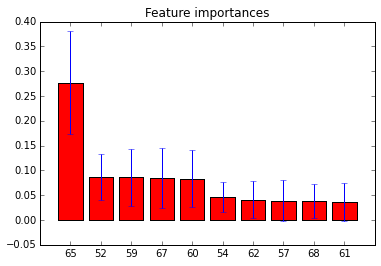

In [39]:
# plot the top ten features

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[0:10]], color="r", yerr=std[indices[0:10]], align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()